# NTL9: hyperparameter-optimized mindist model

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
sys.path.append("/Users/suarezalvareze2/Documents/workspace/NMpathAnalysis/nmpath")
import numpy as np
import pyemma
import mdtraj as md
from glob import glob
import math


from auxfunctions import *
from mfpt import *
from clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel

# Print
from IPython.display import Markdown, display

In [3]:
def plot_its(lags, model, bayesian_model, ax, ylabel, dt=2.0E-4, confidence_interval=0.98):
    cout = 50 * (1.0 - confidence_interval)
    ax.fill_between(
        lags * dt,
        0.0,
        lags * dt,
        alpha=0.5, facecolor='grey')
    ax.plot(lags * dt, lags * dt, linewidth=2, color='black')
    for i in range(model.shape[1]):
        ax.fill_between(
            lags * dt,
            np.percentile(bayesian_model[:, :, i], cout, axis=1),
            np.percentile(bayesian_model[:, :, i], 100 - cout, axis=1),
            alpha=0.3, facecolor='C%d' % i)
        ax.plot(lags * dt, model[:, i], color='C%d' % i)
        ax.plot(lags * dt, np.median(bayesian_model[:, :, i], axis=1), ':o', color='C%d' % i)
    ax.set_xlabel(r'lagtime / $\mu$s')
    ax.set_ylabel(ylabel)
    
def get_lagtime_from_array(lags, lagtime, dt=2.0E-4):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def get_free_energy(tics, bins=100, use=[0, 1]):
    z, xedge, yedge = np.histogram2d(*tics[:, use].T, bins=bins)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    z = np.maximum(z, np.min(z[z > 0]))
    f = -np.log(z)
    f -= np.min(f)
    xx, yy = np.meshgrid(x, y)
    xy = np.array([xx.reshape(-1,), yy.reshape(-1,)]).T
    return dict(x=x, y=y, xx=xx, yy=yy, xy=xy, f=f.T, use=use)

def draw_free_energy(fe, ax, bw=False):
    if bw:
        cmap = mpl.cm.bone
        alpha=0.2
    else:
        cmap = mpl.cm.jet
        alpha=None
    levels = np.linspace(fe['f'].min(), fe['f'].max(), 100, endpoint=False)
    return ax.contourf(fe['x'], fe['y'], fe['f'], levels, cmap=cmap, alpha=alpha, vmin=0.0, vmax=np.max(fe['f']))

def get_metastable_distribution(model, state):
    pi = model.stationary_distribution.copy()
    for i, s in enumerate(model.metastable_sets):
        if i == state:
            continue
        pi[s] = 0.0
    pi /= pi.sum()
    return pi

def printmd(string):
    display(Markdown(string))

def plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list):
    t_cut_values_ns = np.array(t_cut_values)*dt
    t_min_list_ns = np.array(t_min_list)*dt
    t_max_list_ns = np.array(t_max_list)*dt
    t_AB_list_ns = np.array(t_AB_list)*dt

    fig = plt.figure(figsize=(15,3))

    ax1 =  fig.add_subplot(131)
    ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
    ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)
    #ax1.set_xlim(40,105)

    ax2 =  fig.add_subplot(132)
    ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
    ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)
    #ax2.set_xlim(40,105)

    ax3 =  fig.add_subplot(133)
    ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
    ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)
    #ax3.set_xlim(40,105)

    plt.show()

def plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs, step=100):
    max_ = len(t_cut_values)
    select_to_plot= range(0, max_ ,3) # This will print the first column of the free energy plots


    for i in select_to_plot:
        macrostates = big_clusters_list[i]
        rmsd_cluster0=[]
        rmsd_cluster1=[]

        for j, microstate in enumerate(dtrajs[0]):  # There is only one traj
            if j%step == 0:
                if microstate in macrostates[0]:
                    rmsd_cluster0.append(rmsd[j])
                elif (len(macrostates) > 1) and microstate in macrostates[1]:
                    rmsd_cluster1.append(rmsd[j])

        fig = plt.figure(figsize=(5,2))

        plt.hist(rmsd_cluster0, normed=True, bins=25, alpha=0.5,label="cluster-0", edgecolor="r")
        
        if len(macrostates) > 1:
            plt.hist(rmsd_cluster1,normed=True, bins=25, color="b", 
                     alpha=0.5,label="cluster-1", edgecolor="b")

        plt.xlabel("RMSD$(\AA)$",fontsize=12)
        plt.ylabel("Probability Dens.",fontsize=12)
        plt.legend()
        #plt.title("t_cut: {:.2f}ns".format(t_cut_values_ns[i]))
        plt.annotate("t_cut: {:.2f}ns".format(t_cut_values[i]*dt), xy=(1,2))
        plt.xlim([0,7])
        plt.show()


color_sequence = ['#d62728', '#ff9896', '#9467bd',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5', '#98df8a']

## Data source

In [4]:
path  = '/Users/suarezalvareze2/Documents/DESHAWTRAJS/DESRES-Trajectory_NTL9-0-protein/NTL9-0-protein/'
path2 = '/Users/suarezalvareze2/Documents/DESHAWTRAJS/DESRES-Trajectory_NTL9-2-protein/NTL9-2-protein/'
path3 = '/Users/suarezalvareze2/Documents/DESHAWTRAJS/DESRES-Trajectory_NTL9-3-protein/NTL9-3-protein/'
trajs = 'NTL9-0-protein-*.dcd'
trajs2 = 'NTL9-2-protein-*.dcd'
trajs3 = 'NTL9-3-protein-*.dcd'

traj_files = [f for f in sorted(glob(path + trajs))] 
traj_files2 = [f for f in sorted(glob(path2 + trajs2))]
traj_files3 = [f for f in sorted(glob(path3 + trajs3))]

pdb_file = path + 'NTL9.pdb'

## Create a feature reader


In [5]:
features = pyemma.coordinates.featurizer(pdb_file)
features.add_residue_mindist()
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=100000)

01-12-17 13:45:04 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


## Discretization

Following an extensive hyperparameter screening, I found that a TICA lagtime of 200 steps and projecting onto the first 30 eigenvectors yields the best implied timescale convergence.

To accoutn for the high dimensionality, I recommend to use at least 500 discrete states.

In [6]:
# tica = pyemma.coordinates.tica(data=source, lag=200, dim=30)
# cluster = pyemma.coordinates.cluster_kmeans(tica, k=200, max_iter=50)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

01-12-17 15:29:30 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Cluster centers converged after 8 steps.


A Jupyter Widget

A Jupyter Widget

/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


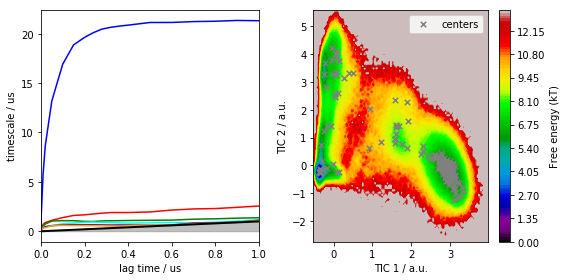

In [7]:
tica = pyemma.coordinates.tica(data=source, lag=200, dim=30).get_output()[0]
cluster = pyemma.coordinates.cluster_kmeans(tica, k=200, max_iter=50)

#lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
lags=np.asarray([1, 10, 50, 100, 250, 500, 750, 1000,
            1200, 1400, 1600, 1800, 2000, 2500,
            3000, 3500, 4000, 4500, 5000])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(cluster.dtrajs, lags=lags, errors=None, nits=6),
    ylog=False, ax=axes[0], units='us', dt=2.0E-4)
pyemma.plots.plot_free_energy(*tica[:, :2].T, ax=axes[1])
axes[1].scatter(*cluster.clustercenters[:,:2].T, marker='x', c='grey', s=30, label='centers')
axes[1].legend()
axes[1].set_xlabel('TIC 1 / a.u.')
axes[1].set_ylabel('TIC 2 / a.u.')
fig.tight_layout()

## CK test

We estimate an MSM at lagtime $\tau$=1500 steps and run a series of CK tests for two, three and four metastable sets.

A Jupyter Widget

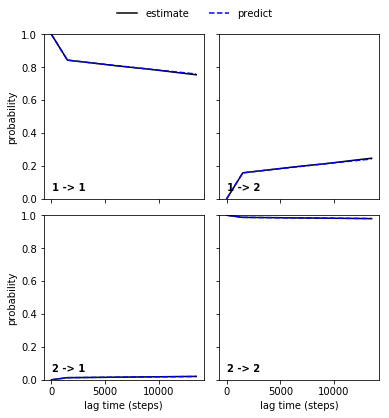

In [8]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=1500, dt_traj='0.0002 us')
pyemma.plots.plot_cktest(msm.cktest(2));

A Jupyter Widget

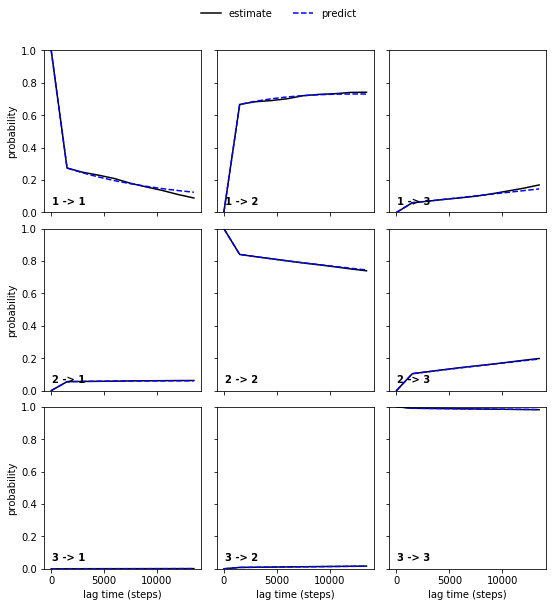

In [9]:
pyemma.plots.plot_cktest(msm.cktest(3));

A Jupyter Widget

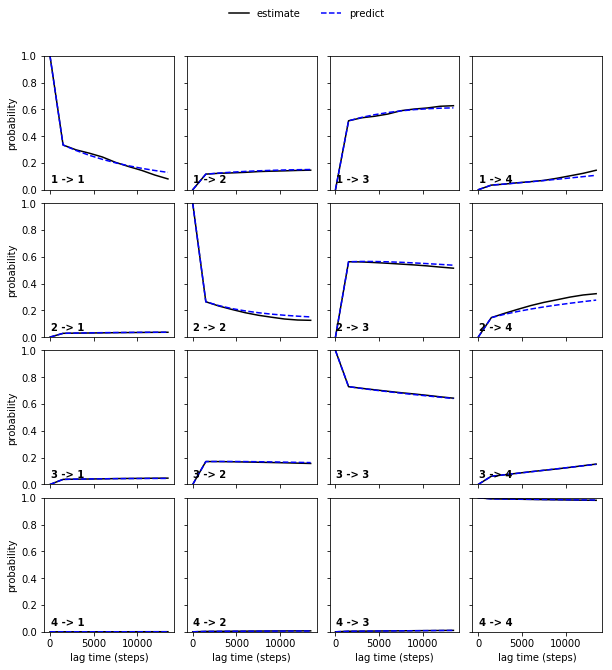

In [10]:
pyemma.plots.plot_cktest(msm.cktest(4));

Apparently, the two metastable state choice yields the best result.

## Timescales

Let's coarse grain the estimated MSM to two states and compute timescales and mean MFPTs for this HMM; the corresponding quantities of the MSM are shown, too.

In [11]:
hmm2 = msm.coarse_grain(2)
print('HMM: %7.2f us' % hmm2.timescales(k=1))
print('MSM: %7.2f us' % msm.timescales(k=1))

HMM:   15.44 us
MSM:   20.59 us


In [12]:
print('HMM: %7.2f us' % hmm2.mfpt(0, 1))
print('MSM: %7.2f us' % msm.mfpt(hmm2.metastable_sets[0], hmm2.metastable_sets[1]))

HMM:   17.22 us
MSM:   21.36 us


In [13]:
print('HMM: %7.2f us' % hmm2.mfpt(1, 0))
print('MSM: %7.2f us' % msm.mfpt(hmm2.metastable_sets[1], hmm2.metastable_sets[0]))

HMM:  164.76 us
MSM:   70.26 us


## Summary

The HMM (and MSM) MFPTs are in very good agreement with the range of (un-)folding timescales in the literature. Sampling frames from both states and visualizing their molecular structures would show which metsatable states were found by the MSM/HMM modelling.

# PART 2: Post Analyses 

### Agglomerative Clustering from the transition matrix

Hierarchical agglomerative clustering using the Markovian commute time: $t_{ij} = \mathrm{MFPT}(i \rightarrow j)+ \mathrm{MFPT}(j \rightarrow i)$.

IMPORTANT: The goal of this clusterig is tho identify macrostates and not to use the best lag-time, the lag-time use for clustering could different from the one that would be appropiate for the final Markov model.

### Lag time = 1 step (just for clustering)

In [14]:
msm1 = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=1, dt_traj='0.0002 us')

In [15]:
lags=np.array([1, 10, 50, 100, 250, 500, 750, 1000,1200, 1400, 1600, 1800, 2000, 2500,3000, 3500, 4000, 4500, 5000])
lag_to_use = [1]
lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]
#range_per_lag = [[3000,8000]]
range_per_lag = [[2000,18000]]

### Clustering

### Lag-time: 0.2ns

#### t_values:

t_cut: 400.00ns, t_min: 445.26ns, t_max: 5.69e+05ns, tAB: 368.40ns


/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


t_cut: 613.20ns, t_min: 615.36ns, t_max: 5.69e+05ns, tAB: 368.40ns
t_cut: 826.40ns, t_min: 858.55ns, t_max: 5.69e+05ns, tAB: 368.40ns
t_cut: 1039.60ns, t_min: 1052.68ns, t_max: 5.69e+05ns, tAB: 368.40ns
t_cut: 1252.80ns, t_min: 1261.80ns, t_max: 5.69e+05ns, tAB: 368.40ns
t_cut: 1466.00ns, t_min: 1481.24ns, t_max: 5.69e+05ns, tAB: 368.40ns
t_cut: 1679.20ns, t_min: 1696.09ns, t_max: 5.69e+05ns, tAB: 368.40ns
t_cut: 1892.40ns, t_min: 1937.29ns, t_max: 5.69e+05ns, tAB: 368.40ns
t_cut: 2105.60ns, t_min: 2119.59ns, t_max: 5.69e+05ns, tAB: 368.40ns
t_cut: 2318.80ns, t_min: 2408.83ns, t_max: 5.69e+05ns, tAB: 368.40ns
t_cut: 2532.00ns, t_min: 2557.32ns, t_max: 5.69e+05ns, tAB: 368.40ns
t_cut: 2745.20ns, t_min: 2775.52ns, t_max: 5.69e+05ns, tAB: 368.40ns
t_cut: 2958.40ns, t_min: 2979.73ns, t_max: 5.69e+05ns, tAB: 0.00ns
t_cut: 3171.60ns, t_min: 3360.54ns, t_max: 5.69e+05ns, tAB: 0.00ns
t_cut: 3384.80ns, t_min: 3409.03ns, t_max: 5.69e+05ns, tAB: 0.00ns


#### Observed clusters vs t_cut

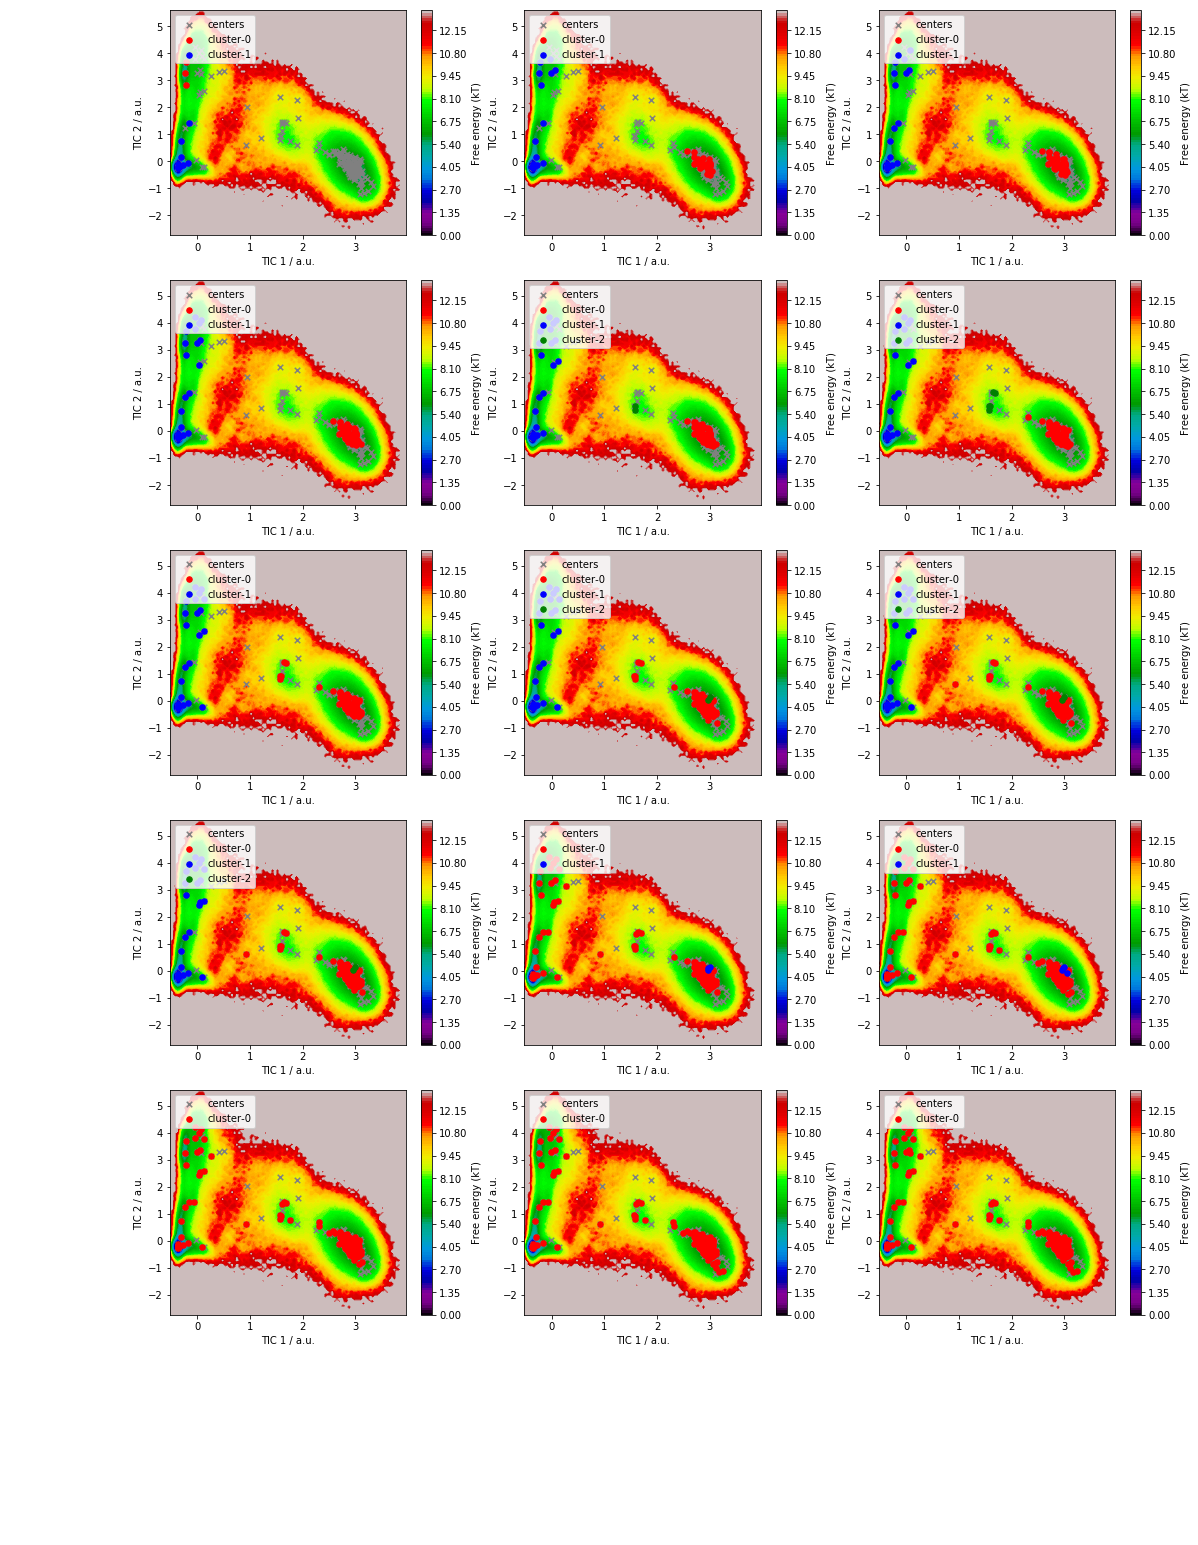

#### t_AB plots:

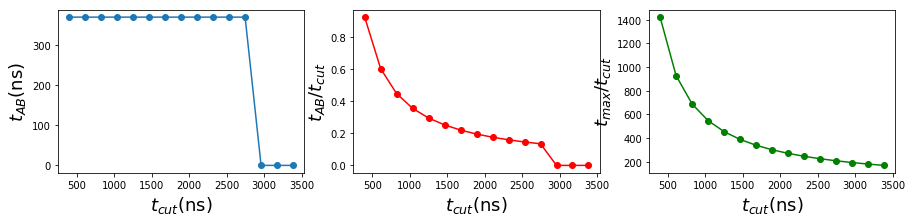

In [16]:
K = msm1.P
dt = 0.2
#---------------------
printmd("### Lag-time: "+str(dt)+"ns")

t_min_list=[]
t_max_list=[]
t_AB_list=[]

big_clusters_list = []

# t_cut range
min_ = range_per_lag[0][0]
max_ = range_per_lag[0][1]
interval = (max_ - min_)//15 
t_cut_values =  [min_+i for i in range(0,max_- min_,interval)][0:15]


fig_n_cols = 3
fig_n_rows = int(math.ceil(len(t_cut_values)/fig_n_cols))


fig = plt.figure(figsize=(6*fig_n_cols, 4.8*fig_n_rows))

printmd("#### t_values:")

for ii, t_cut in enumerate(t_cut_values):

    big_clusters=[]
    big_clusters_index =[]

    # clustering
    clusters, t_min, t_max, clustered_tmatrix = kinetic_clustering_from_tmatrix(K, t_cut=t_cut, verbose=False)
    #clusters, t_min, t_max = kinetic_clustering2_from_tmatrix(K, t_cut=t_cut, verbose=False)


    t_min_list.append(t_min)
    t_max_list.append(t_max)

    for i, cluster_i in enumerate(clusters):
        if len(cluster_i) > 1:
            big_clusters.append(cluster_i)
            big_clusters_index.append(i)

    n_big = len(big_clusters)

    macrostates = biggest_clusters_indexes(big_clusters, n_pick=2)
    #macrostates_list.append([ clusters[macrostates[i]] for i in range(len(macrostates))])
    big_clusters_list.append(big_clusters)

    if n_big > 1:
        #tAB = markov_commute_time(clustered_tmatrix,[macrostates[0]],[macrostates[1]] )
        tAB = markov_commute_time(K,[macrostates[0]],[macrostates[1]] )
    else:
        tAB = 0.0
    t_AB_list.append(tAB)

    print("t_cut: {:.2f}ns, t_min: {:.2f}ns, t_max: {:.2e}ns, tAB: {:.2f}ns".format(t_cut*dt, t_min*dt, t_max*dt, tAB*dt))

    plt.subplot(fig_n_rows, fig_n_cols, ii+1)
    pyemma.plots.plot_free_energy(*tica[:,:2].T)
    plt.scatter(*cluster.clustercenters[:,:2].T, marker='x', c='grey', s=30, label='centers')
    plt.annotate("t_cut: {:.2f}ns".format(t_cut*dt), xy=(-0.8,-4))

    colors = ['red','blue','green','black','orange'] + color_sequence

    for i, cluster_i in enumerate(big_clusters):
        cluster_i_tica_xy = []
        for index in cluster_i:
            cluster_i_tica_xy.append(cluster.clustercenters[:,:2][index])
        cluster_i_tica_xy = np.array(cluster_i_tica_xy)
        plt.scatter(*cluster_i_tica_xy.T, marker='o', c=colors[i], s=30, label='cluster-'+str(i))

    plt.legend(loc='upper left')
    plt.xlabel('TIC 1 / a.u.')
    plt.ylabel('TIC 2 / a.u.')
        
printmd("#### Observed clusters vs t_cut")
plt.show()

printmd("#### t_AB plots:")
plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list)

# Selecting t_cut = 2000ns for mfpts calculations

In [17]:
dt = 0.0002 # in micro-sec

stateA = big_clusters_list[2][1]  #Folded
stateB = big_clusters_list[2][0]   #Unfolded


lag_to_use = np.asarray(list(lags[0::2]) + [5000, 10000, 15000, 20000, 30000])

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]

# MSM estimation
msm_models = [pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us') for lag in lag_to_use]

msm_mfptAB = np.asarray([msm_models[i].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm_models[i].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

In [18]:
model1 = NonMarkovModel(cluster.dtrajs, stateA, stateB)
model1.popA, model1.popB

(0.87483246583249974, 0.055368914182082091)

In [19]:
kinetics = model1.mfpts()
dt = 0.0002
print(kinetics['mfptAB']*dt,kinetics['mfptBA']*dt)

16.3454663233 1.85751920548


In [21]:
kinetics = model1.empirical_mfpts()
print(kinetics['mfptAB']*dt,kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 61/62
13.789970491803277 1.8576870967741936


In [ ]:
29(7)     175(47)    